<table style="font-size: 1em; padding: 0; margin: 0;">
<p style="border: 1px solid #ff5733; border-left: 15px solid #ff5733; padding: 10px; text-align:justify;">
    <strong style="color: #ff5733">Deliverable</strong>  
    <br/>The deliverable for Part 4 is a jupyter notebook showing a workflow to train and test U-Net models for training using augmented NWPU-RESISC45 lake images and corresponding labels, and using augmented sentinel-2 cloudless imagery and corresponding labels. So, there are two U-Net based models in total. You should compare their outputs. Finally, you should test the model trained on NWPU imagery on the s2cloudless imagery.  This will mostly test your understanding of the generic yet complex workflow of training, testing and comparing models based on a test data set, as well as how to interpret evaluation metrics. The baseline evaluation of testing the model trained on NWPU imagery on the s2cloudless imagery (in machine learning called "transfer learning") is what you will optimize in Part 5.
    </p>

In [1]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Importando librerias

In [3]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
import numpy as np
import json, os
from random import shuffle
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

#### Usamos funcion IoU

In [4]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = tf.keras.backend.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

#### Usamos funcion Unet

In [5]:
def unet(sz = (512, 512, 3)):
  inputs = Input(sz)
  _ = inputs
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    _ = Conv2D(f, 3, activation='relu', padding='same') (_)
    _ = Conv2D(f, 3, activation='relu', padding='same') (_)
    layers.append(_)
    _ = MaxPooling2D() (_)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  _ = Conv2D(f, 3, activation='relu', padding='same') (_)
  _ = Conv2D(f, 3, activation='relu', padding='same') (_)
  _ = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (_)
  _ = Concatenate(axis=3)([_, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    _ = Conv2D(f, 3, activation='relu', padding='same') (_)
    _ = Conv2D(f, 3, activation='relu', padding='same') (_)
    _ = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (_)
    _ = Concatenate(axis=3)([_, layers[j]])
    j = j -1 
    
  #classification 
  _ = Conv2D(f, 3, activation='relu', padding='same') (_)
  _ = Conv2D(f, 3, activation='relu', padding='same') (_)
  outputs = Conv2D(1, 1, activation='sigmoid') (_)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model  

In [7]:
model = unet()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 512, 512, 8)  224         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 512, 512, 8)  584         conv2d_27[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 256, 256, 8)  0           conv2d_28[0][0]                  
____________________________________________________________________________________________

In [8]:
# inheritance for training process plot 
class PlotLearning(tf.keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        infile = f'nwpu_images/data/{path}'
        raw = Image.open(infile)
        raw = np.array(raw.resize((512, 512)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = 255*model.predict(np.expand_dims(raw, 0)).squeeze()
        print(np.max(pred))
                
        #mask post-processing 
        msk  = (pred>60).astype('int') #100       
        msk = np.stack((msk,)*3, axis=-1)
        #msk[msk >= 0.5] = 1 
        #msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

In [9]:
def build_callbacks():
        checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

In [10]:
def image_batch_generator(files, batch_size = 32, sz = (512, 512)):
  
  while True: # this is here because it will be called repeatedly by the training function
    
    #extract a random subset of files of length "batch_size"
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs (x) and outputs (y)
    batch_x = []
    batch_y = []
    
    #cycle through each image in the batch
    for f in batch:

        #preprocess the raw images 
        rawfile = f'nwpu_images/data/{f}'
        raw = Image.open(rawfile)
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
            raw = np.stack((raw,)*3, axis=-1)

        else:
            raw = raw[:,:,0:3]
            
        #get the image dimensions, find the min dimension, then square the image off    
        nx, ny, nz = np.shape(raw)
        n = np.minimum(nx,ny)
        raw = raw[:n,:n,:] 
            
        batch_x.append(raw)
        
        #get the masks. 
        maskfile = rawfile.replace('nwpu_images','nwpu_label_images')+'_mask.jpg'
        mask = Image.open(maskfile)
        # the mask is 3-dimensional so get the max in each channel to flatten to 2D
        mask = np.max(np.array(mask.resize(sz)),axis=2)
        # water pixels are always greater than 100
        mask = (mask>100).astype('int')
        
        mask = mask[:n,:n]

        batch_y.append(mask)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255. #divide image by 255 to normalize
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3) #add singleton dimension to batch_y

    yield (batch_x, batch_y) #yield both the image and the label together

Define our one hyperparameter (batch size), the proportion of the dataset to use for training (60%), then get all the files, shuffle them randomly, draw 60% for training, then use the rest for testing

In [11]:
batch_size = 8

prop_train = 0.6

all_files = os.listdir('nwpu_images/data')
shuffle(all_files)

split = int(prop_train * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

In [12]:
train_generator = image_batch_generator(train_files, batch_size = batch_size)
test_generator  = image_batch_generator(test_files, batch_size = batch_size)

In [13]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size

print(train_steps)
print(test_steps)

42
28


  ...
    to  
  ['...']
  ...
    to  
  ['...']
i= 1 loss= 0.5567600500015986 val_loss= 0.49600186411823544 mean_iou= 0.026205653 val_mean_iou= 0.07193543
127.5665


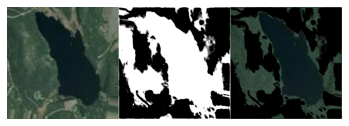

i= 2 loss= 0.5055331403300876 val_loss= 0.4996363967657089 mean_iou= 0.1702608 val_mean_iou= 0.1688859
136.44186


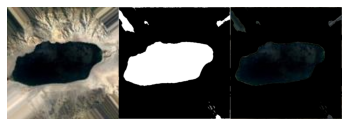

i= 3 loss= 0.48685404871191296 val_loss= 0.4742117705089705 mean_iou= 0.19408858 val_mean_iou= 0.17265399
133.94725


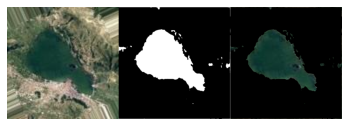

i= 4 loss= 0.4723365462961651 val_loss= 0.4442754483648709 mean_iou= 0.1716074 val_mean_iou= 0.1296399
112.58244


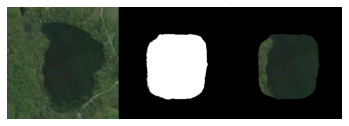

i= 5 loss= 0.4259615916581381 val_loss= 0.4258440158196858 mean_iou= 0.25347495 val_mean_iou= 0.3037123
162.32133


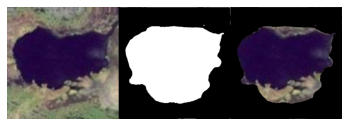

i= 6 loss= 0.42286980010214303 val_loss= 0.38752453454903196 mean_iou= 0.33579582 val_mean_iou= 0.34006715
177.00839


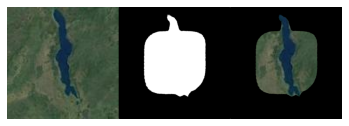

i= 7 loss= 0.4193045057001568 val_loss= 0.4055341492806162 mean_iou= 0.33886066 val_mean_iou= 0.39963204
163.2237


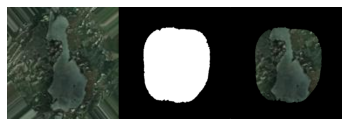

i= 8 loss= 0.4404259217636926 val_loss= 0.4173093480723245 mean_iou= 0.30717483 val_mean_iou= 0.38850144
202.00848


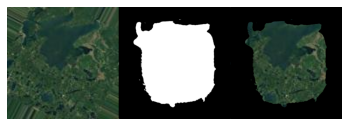

i= 9 loss= 0.40716267554532914 val_loss= 0.4017276146582195 mean_iou= 0.34072292 val_mean_iou= 0.3343689
166.6976


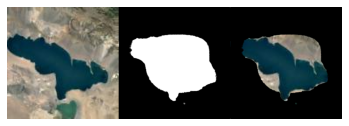

i= 10 loss= 0.41452760426771074 val_loss= 0.42745059728622437 mean_iou= 0.38598007 val_mean_iou= 0.3597303
165.58858


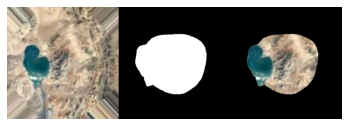

i= 11 loss= 0.4069438016130811 val_loss= 0.4423750990203449 mean_iou= 0.41764608 val_mean_iou= 0.41580886
246.88673


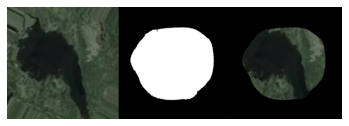

i= 12 loss= 0.4077349099374953 val_loss= 0.5129138688955989 mean_iou= 0.3760978 val_mean_iou= 0.10624653
151.26495


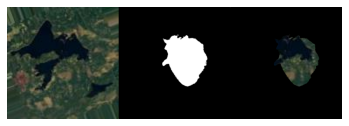

i= 13 loss= 0.41431716581185657 val_loss= 0.40466408750840593 mean_iou= 0.38018668 val_mean_iou= 0.42764774
230.78033


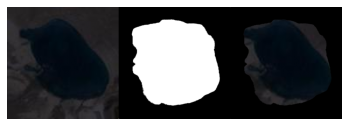

i= 14 loss= 0.3964627356756301 val_loss= 0.4041544475725719 mean_iou= 0.3889623 val_mean_iou= 0.3283846
169.67378


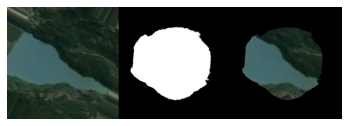

i= 15 loss= 0.4063056033282053 val_loss= 0.4132292866706848 mean_iou= 0.37322152 val_mean_iou= 0.34171733
150.50899


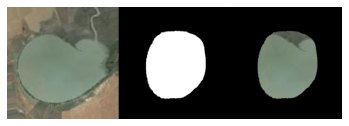

i= 16 loss= 0.3928421898966744 val_loss= 0.41417153818266733 mean_iou= 0.39679495 val_mean_iou= 0.28296265
173.56195


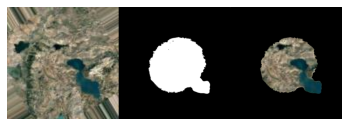

i= 17 loss= 0.40520550381569637 val_loss= 0.41246537970645086 mean_iou= 0.3631531 val_mean_iou= 0.3169338
155.08324


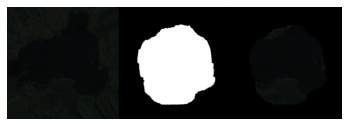

i= 18 loss= 0.4040789327451161 val_loss= 0.3976431382553918 mean_iou= 0.37217775 val_mean_iou= 0.41614884
205.20311


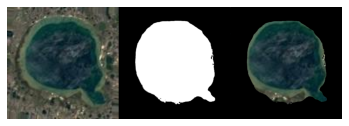

i= 19 loss= 0.40437749524911243 val_loss= 0.4038067917738642 mean_iou= 0.39745563 val_mean_iou= 0.4163165
179.5823


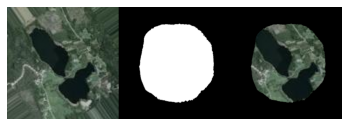

i= 20 loss= 0.3949803617738542 val_loss= 0.39911599244390217 mean_iou= 0.40997013 val_mean_iou= 0.3837401
173.66187


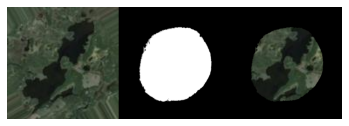

i= 21 loss= 0.39765999572617666 val_loss= 0.41258752452475683 mean_iou= 0.3747645 val_mean_iou= 0.39749688
214.83212


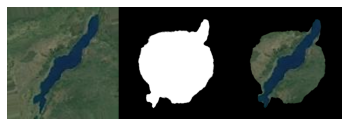

i= 22 loss= 0.3977810364393961 val_loss= 0.40885752333062036 mean_iou= 0.3835629 val_mean_iou= 0.29347548
162.98724


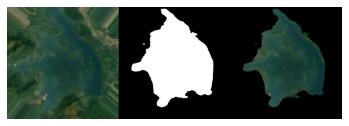

i= 23 loss= 0.39430212052095504 val_loss= 0.4069160574248859 mean_iou= 0.38345563 val_mean_iou= 0.3744421
192.32957


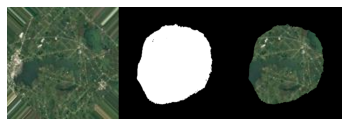

i= 24 loss= 0.397296945254008 val_loss= 0.3934165579932077 mean_iou= 0.37319082 val_mean_iou= 0.373779
199.14294


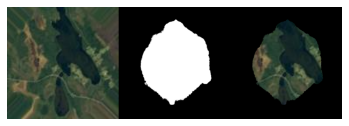

i= 25 loss= 0.39611037217435385 val_loss= 0.4016095186982836 mean_iou= 0.372265 val_mean_iou= 0.3306194
182.33865


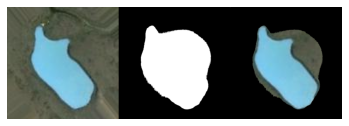

i= 26 loss= 0.4004927050499689 val_loss= 0.4024093140448843 mean_iou= 0.392817 val_mean_iou= 0.42161018
220.41217


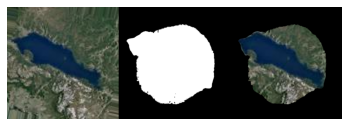

i= 27 loss= 0.39818466774054934 val_loss= 0.4012072192771094 mean_iou= 0.40373203 val_mean_iou= 0.33439595
178.38853


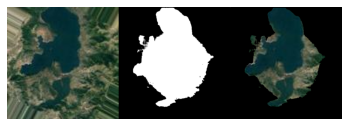

i= 28 loss= 0.3998219647577831 val_loss= 0.404168324811118 mean_iou= 0.38501525 val_mean_iou= 0.4161372
210.25385


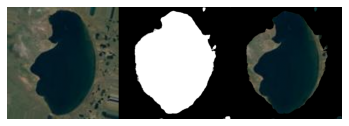

i= 29 loss= 0.39587935663404916 val_loss= 0.3951327843325479 mean_iou= 0.4033543 val_mean_iou= 0.39621755
189.47997


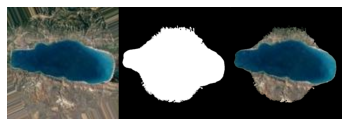

i= 30 loss= 0.39545662701129913 val_loss= 0.40033307139362606 mean_iou= 0.38890338 val_mean_iou= 0.40838614
174.89307


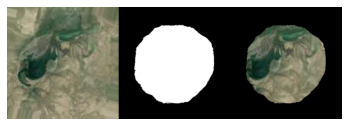

i= 31 loss= 0.3957044354506901 val_loss= 0.3972674842391695 mean_iou= 0.38802588 val_mean_iou= 0.41131616
177.83244


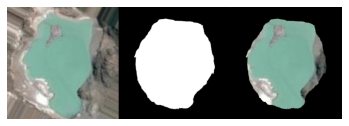

i= 32 loss= 0.3962287413222449 val_loss= 0.40964845355067936 mean_iou= 0.40559292 val_mean_iou= 0.41261098
186.05794


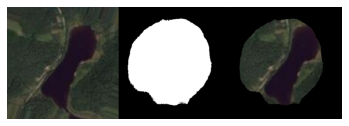

i= 33 loss= 0.40307837653727757 val_loss= 0.3996208331414631 mean_iou= 0.37344393 val_mean_iou= 0.36003587
183.02843


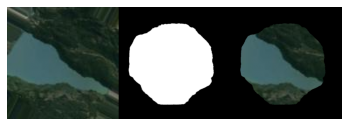

i= 34 loss= 0.3946472250279926 val_loss= 0.40059780329465866 mean_iou= 0.3785189 val_mean_iou= 0.38279757
170.72118


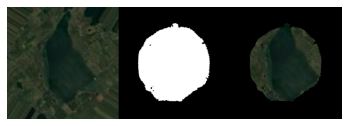

i= 35 loss= 0.3946784330265863 val_loss= 0.3899285750729697 mean_iou= 0.4059925 val_mean_iou= 0.38748708
196.85878


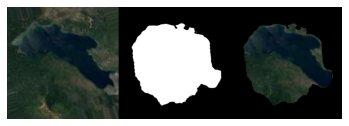

i= 36 loss= 0.39664514646643684 val_loss= 0.40982020114149365 mean_iou= 0.391622 val_mean_iou= 0.3757484
180.46889


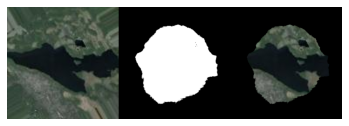

i= 37 loss= 0.4059467485972813 val_loss= 0.39951735947813305 mean_iou= 0.37355676 val_mean_iou= 0.3432076
172.07991


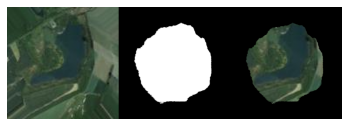

i= 38 loss= 0.40267918649173917 val_loss= 0.3916619196534157 mean_iou= 0.39138627 val_mean_iou= 0.43927708
217.09842


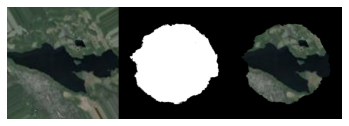

i= 39 loss= 0.3942414862768991 val_loss= 0.3941691443324089 mean_iou= 0.3850876 val_mean_iou= 0.4012246
213.34297


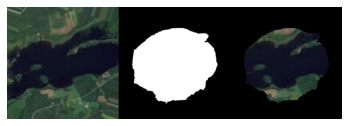

i= 40 loss= 0.3875331786416826 val_loss= 0.42431778673614773 mean_iou= 0.40431404 val_mean_iou= 0.4125916
186.41483


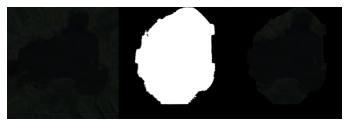

i= 41 loss= 0.39627250532309216 val_loss= 0.41324863902160097 mean_iou= 0.39945903 val_mean_iou= 0.396296
223.84029


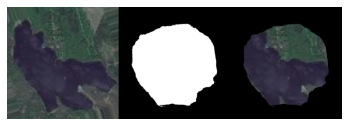

i= 42 loss= 0.39721464968862985 val_loss= 0.41251703245299204 mean_iou= 0.39444706 val_mean_iou= 0.40453976
205.32607


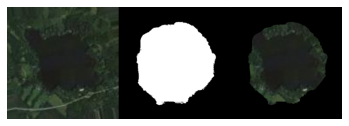

i= 43 loss= 0.3920112010978517 val_loss= 0.4011204604591642 mean_iou= 0.3863647 val_mean_iou= 0.3552687
185.42851


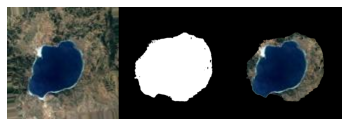

i= 44 loss= 0.3962385831844239 val_loss= 0.4053232456956591 mean_iou= 0.36585927 val_mean_iou= 0.3851804
185.26112


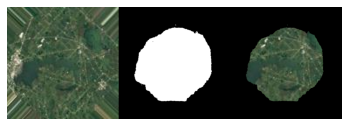

i= 45 loss= 0.38463155428568524 val_loss= 0.401347961808954 mean_iou= 0.3930507 val_mean_iou= 0.38518164
211.56189


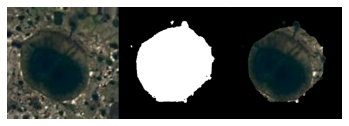

i= 46 loss= 0.4013945964120683 val_loss= 0.4035159008843558 mean_iou= 0.38699728 val_mean_iou= 0.368074
184.60039


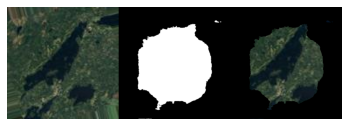

i= 47 loss= 0.3986861996707462 val_loss= 0.3974492188010897 mean_iou= 0.38237372 val_mean_iou= 0.35437486
205.35715


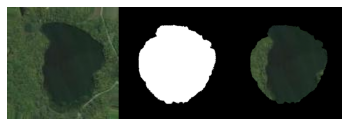

i= 48 loss= 0.399268517891566 val_loss= 0.39394745762859074 mean_iou= 0.3823014 val_mean_iou= 0.36052892
182.72943


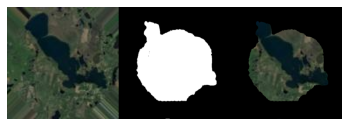

i= 49 loss= 0.39434038741247995 val_loss= 0.39623853883572985 mean_iou= 0.39531407 val_mean_iou= 0.4307697
219.0084


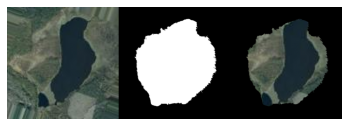

i= 50 loss= 0.3912258283013389 val_loss= 0.4049348905682564 mean_iou= 0.39331123 val_mean_iou= 0.33218545
181.23894


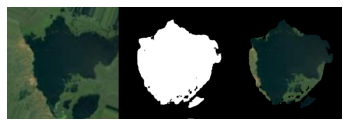

i= 51 loss= 0.39027977344535647 val_loss= 0.41812131979635786 mean_iou= 0.395651 val_mean_iou= 0.3595921
200.16548


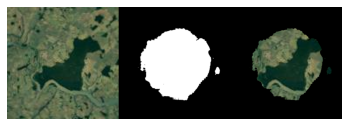

i= 52 loss= 0.38868897940431324 val_loss= 0.4043084808758327 mean_iou= 0.41321895 val_mean_iou= 0.4035735
210.9379


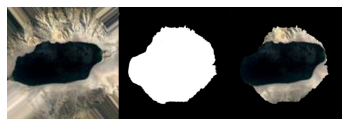

i= 53 loss= 0.3927216288589296 val_loss= 0.40195489355496 mean_iou= 0.4035237 val_mean_iou= 0.38871464
182.06996


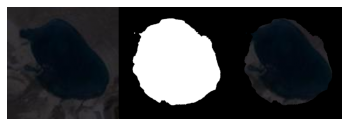

i= 54 loss= 0.3959951102733612 val_loss= 0.4076734728046826 mean_iou= 0.3966561 val_mean_iou= 0.36983582
200.91809


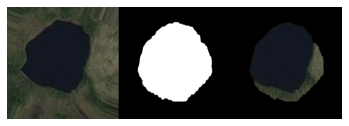

i= 55 loss= 0.39015989289397285 val_loss= 0.39075008034706116 mean_iou= 0.37352985 val_mean_iou= 0.36288065
205.5632


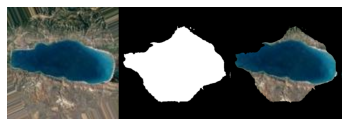

i= 56 loss= 0.38992485333056676 val_loss= 0.4014749016080584 mean_iou= 0.41177496 val_mean_iou= 0.31407174
207.26411


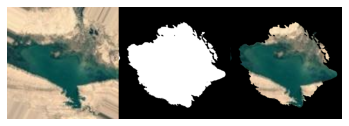

i= 57 loss= 0.38845798798969816 val_loss= 0.40920996346643995 mean_iou= 0.39525333 val_mean_iou= 0.37274224
209.16026


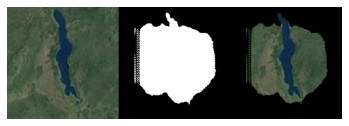

i= 58 loss= 0.3913753231366475 val_loss= 0.4068941218512399 mean_iou= 0.3987848 val_mean_iou= 0.3546844
191.61142


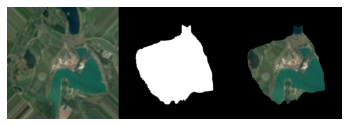

i= 59 loss= 0.37466123416310265 val_loss= 0.41869321359055384 mean_iou= 0.40370318 val_mean_iou= 0.4180242
222.91978


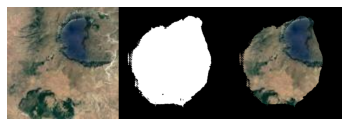

i= 60 loss= 0.3801931341489156 val_loss= 0.4142933317593166 mean_iou= 0.4205114 val_mean_iou= 0.3879685
202.79892


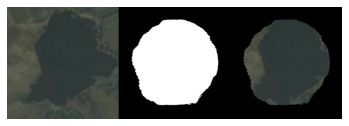

i= 61 loss= 0.3738418782041186 val_loss= 0.4304517422403608 mean_iou= 0.4139947 val_mean_iou= 0.31168875
183.48816


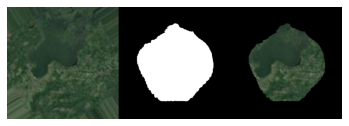

i= 62 loss= 0.37666405950273785 val_loss= 0.4366088520203318 mean_iou= 0.42053068 val_mean_iou= 0.26367483
188.40129


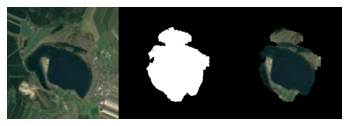

i= 63 loss= 0.37542818060943056 val_loss= 0.41648571831839426 mean_iou= 0.4338338 val_mean_iou= 0.36791372
199.27144


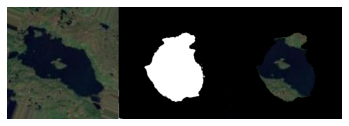

i= 64 loss= 0.3586974023353486 val_loss= 0.41325520085436956 mean_iou= 0.445753 val_mean_iou= 0.41254875
231.56625


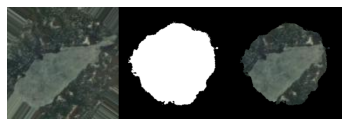

i= 65 loss= 0.35822313172476633 val_loss= 0.46949758380651474 mean_iou= 0.44909114 val_mean_iou= 0.399582
252.5191


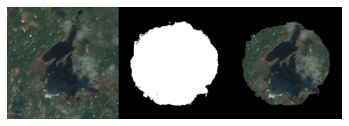

i= 66 loss= 0.3590115393911089 val_loss= 0.4373315115060125 mean_iou= 0.43475738 val_mean_iou= 0.30832154
208.59962


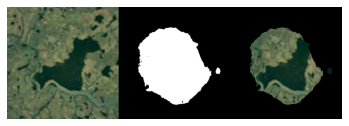

i= 67 loss= 0.3475181588104793 val_loss= 0.43934559502771925 mean_iou= 0.4451502 val_mean_iou= 0.32809916
223.06052


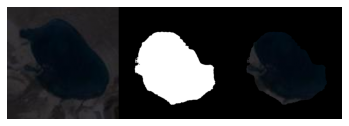

i= 68 loss= 0.35601326752276646 val_loss= 0.4454076098544257 mean_iou= 0.44628447 val_mean_iou= 0.32866976
220.21712


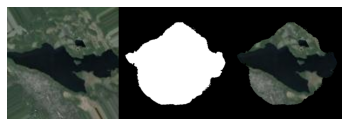

i= 69 loss= 0.35124876882348743 val_loss= 0.41774485792432514 mean_iou= 0.46767485 val_mean_iou= 0.37755662
233.3208


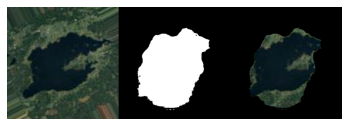

i= 70 loss= 0.34258513649304706 val_loss= 0.4250783867069653 mean_iou= 0.47782084 val_mean_iou= 0.39258385
202.48499


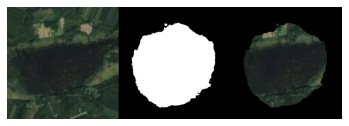

i= 71 loss= 0.3247067974436851 val_loss= 0.4477011635899544 mean_iou= 0.49933514 val_mean_iou= 0.37036318
238.07413


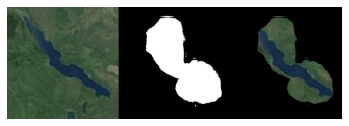

i= 72 loss= 0.3198393647159849 val_loss= 0.45579480805567335 mean_iou= 0.505696 val_mean_iou= 0.34397122
209.70227


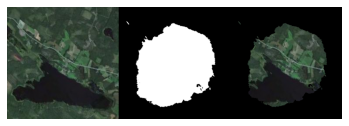

i= 73 loss= 0.3270739959109397 val_loss= 0.4381345180528505 mean_iou= 0.5174705 val_mean_iou= 0.3526332
241.3791


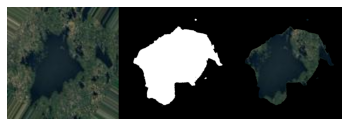

i= 74 loss= 0.32638013930547805 val_loss= 0.4792297993387495 mean_iou= 0.4865735 val_mean_iou= 0.29305983
221.34114


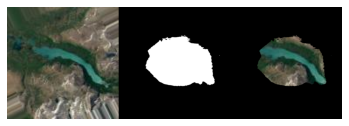

i= 75 loss= 0.3156189354402678 val_loss= 0.4572845165218626 mean_iou= 0.51069915 val_mean_iou= 0.29609028
182.85269


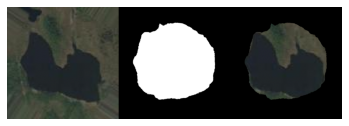

i= 76 loss= 0.29913446803887683 val_loss= 0.49807650595903397 mean_iou= 0.53836924 val_mean_iou= 0.39468673
254.95763


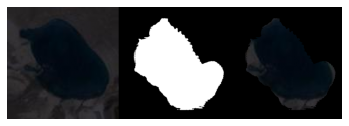

i= 77 loss= 0.3060930608993485 val_loss= 0.4694615772792271 mean_iou= 0.5284476 val_mean_iou= 0.28164837
254.96599


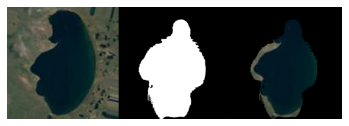

i= 78 loss= 0.30181130341121126 val_loss= 0.47406885985817226 mean_iou= 0.5272534 val_mean_iou= 0.33282304
193.01695


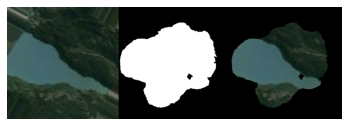

i= 79 loss= 0.3052937438090642 val_loss= 0.4410066891993795 mean_iou= 0.5491136 val_mean_iou= 0.32893458
200.83423


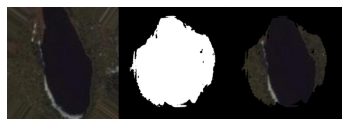

i= 80 loss= 0.3009700363590604 val_loss= 0.5449862735612052 mean_iou= 0.5512048 val_mean_iou= 0.3512471
241.57307


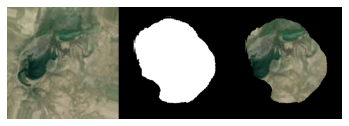

i= 81 loss= 0.2817457165746462 val_loss= 0.4677391829235213 mean_iou= 0.5652185 val_mean_iou= 0.39269426
242.55733


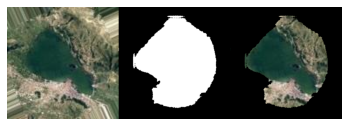

i= 82 loss= 0.2742082732064383 val_loss= 0.5104548739535468 mean_iou= 0.57500005 val_mean_iou= 0.29621655
204.8111


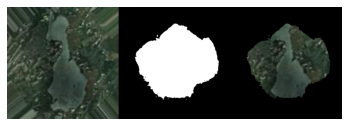

i= 83 loss= 0.2632773050240108 val_loss= 0.5623600674527032 mean_iou= 0.58777887 val_mean_iou= 0.3656643
254.96747


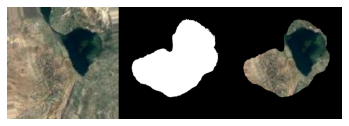

i= 84 loss= 0.26431292082582203 val_loss= 0.5060854841555867 mean_iou= 0.5918773 val_mean_iou= 0.19620068
184.04845


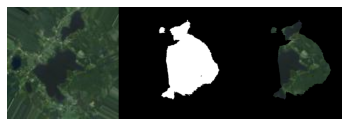

i= 85 loss= 0.2639708582844053 val_loss= 0.5198789409228733 mean_iou= 0.58390856 val_mean_iou= 0.26138237
147.53311


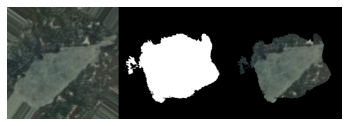

i= 86 loss= 0.2348988535148757 val_loss= 0.5369002606187548 mean_iou= 0.62867725 val_mean_iou= 0.33392903
254.99979


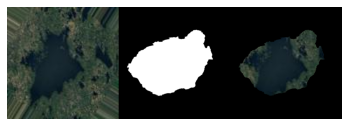

i= 87 loss= 0.24666872514145716 val_loss= 0.5338764116168022 mean_iou= 0.60676926 val_mean_iou= 0.35438707
211.60254


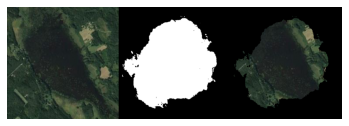

i= 88 loss= 0.24721900409176237 val_loss= 0.5401421987584659 mean_iou= 0.62635434 val_mean_iou= 0.3242297
247.57545


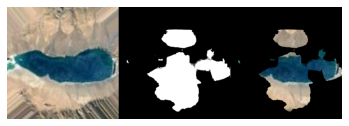

i= 89 loss= 0.23525249603248777 val_loss= 0.6714661696127483 mean_iou= 0.62752783 val_mean_iou= 0.35357088
254.92737


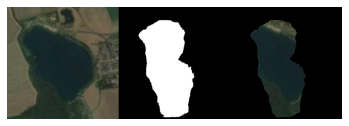

i= 90 loss= 0.23365614172958193 val_loss= 0.5458572294030871 mean_iou= 0.6411811 val_mean_iou= 0.35964045
252.24612


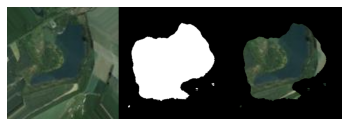

i= 91 loss= 0.2506135602792104 val_loss= 0.652498368706022 mean_iou= 0.6121037 val_mean_iou= 0.31628728
248.22438


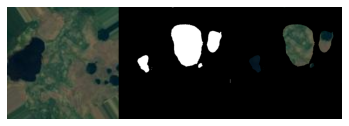

i= 92 loss= 0.22529704868793488 val_loss= 0.5644815979259354 mean_iou= 0.6558984 val_mean_iou= 0.37780237
248.63246


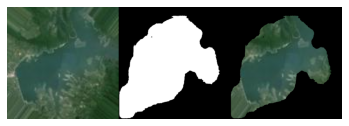

i= 93 loss= 0.24405995117766516 val_loss= 0.5601462892123631 mean_iou= 0.62441725 val_mean_iou= 0.29872403
248.46474


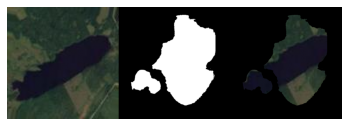

i= 94 loss= 0.21030319553046 val_loss= 0.654822479401316 mean_iou= 0.6656351 val_mean_iou= 0.31945732
206.9734


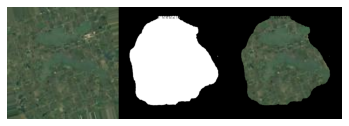

i= 95 loss= 0.2100029978014174 val_loss= 0.60507939436606 mean_iou= 0.6812202 val_mean_iou= 0.3536815
247.62057


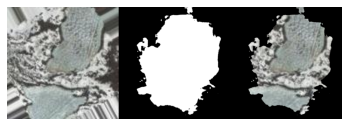

i= 96 loss= 0.20219337124200093 val_loss= 0.5691957186375346 mean_iou= 0.6814294 val_mean_iou= 0.35694906
254.98659


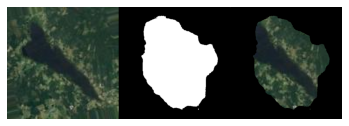

i= 97 loss= 0.2055873384787923 val_loss= 0.6488659339291709 mean_iou= 0.67453134 val_mean_iou= 0.28717965
254.85083


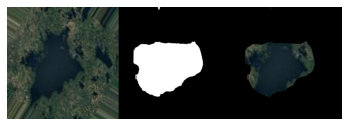

i= 98 loss= 0.19742144786176227 val_loss= 0.685089861708028 mean_iou= 0.69203305 val_mean_iou= 0.36560747
254.99474


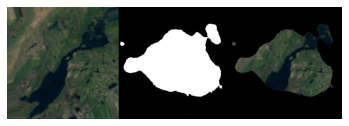

i= 99 loss= 0.20183941030076571 val_loss= 0.648882229413305 mean_iou= 0.69405645 val_mean_iou= 0.28724337
239.8863


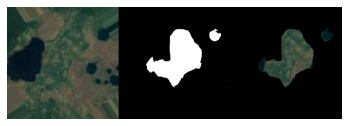

i= 100 loss= 0.19024795063194774 val_loss= 0.8023237415722438 mean_iou= 0.7021348 val_mean_iou= 0.32230687
254.28464


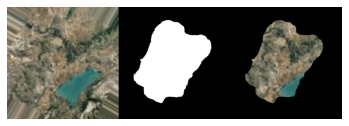

In [14]:
history = model.fit(train_generator, 
                    epochs = 100, steps_per_epoch = train_steps,
                    validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0,
                    use_multiprocessing=False)

In [15]:
print(history.history.keys())

dict_keys(['loss', 'mean_iou', 'val_loss', 'val_mean_iou'])


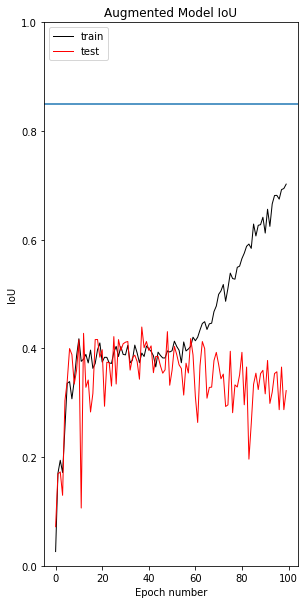

In [16]:
# summarize history for iou
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.plot(history.history['mean_iou'],'k',lw=1) #plot the training iou curve
plt.plot(history.history['val_mean_iou'],'r',lw=1) #plot the testing iou curve
plt.ylim(0,1) #put limits of y axis
plt.axhline(y=0.85) #draw a horizontal line at 85% IoU
plt.title('Augmented Model IoU') #add title, labels and a legend
plt.ylabel('IoU')
plt.xlabel('Epoch number')
plt.legend(['train', 'test'], loc='upper left')

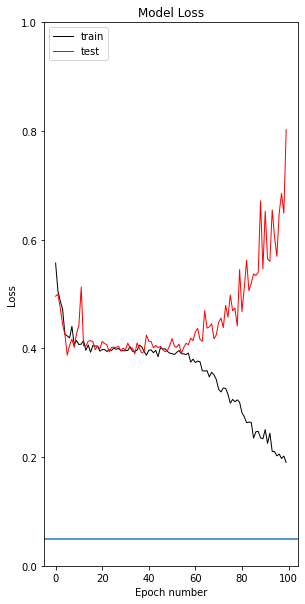

In [17]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.plot(history.history['loss'],'k',lw=1)
plt.plot(history.history['val_loss'],'r',lw=1)
plt.ylim(0,1)
plt.axhline(y=0.05)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch number')
plt.legend(['train', 'test'], loc='upper left')

Probando con data de NWPU-images

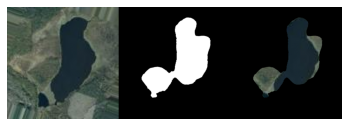

In [18]:
# open an image 
raw = Image.open('nwpu_images'+os.sep+'data'+os.sep+test_files[0])

# resize and rescale, which is what the model is expecting as inputs
raw = np.array(raw.resize((512, 512)))/255.
##raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
# binarize
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

Probando con data de S2cloudless-imagery

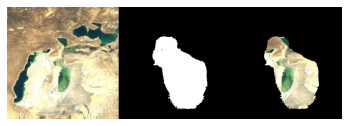

In [20]:
# open an image 
raw = Image.open('s2cloudless_imagery'+os.sep+'data'+os.sep+'aral_sea_s2cloudless-2016.jpg')

# resize and rescale, which is what the model is expecting as inputs
raw = np.array(raw.resize((512, 512)))/255.
##raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
# binarize
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()